### Paralelismo do Alinhamento de Sequências de DNA

###### Beatriz Rianho Bernardino
---

Dentro da bioInformática, o alinhamento de sequências de DNA possui extrema importância para a identificação de padrões e nível de indentidade entre nucleotídeos ou proteínas. Esse mecanismo auxilia, por exemplo, na detecção de mutações de vírus, identificação de genomas desconhecidos e no mapeamento de sequências expressas dentro de um genoma.

Para que tal alinhamento seja possível, existem diferentes estratégias computacionais que podem ser utilizadas. Como as sequências de DNA têm um tamanho elevado, é necessário levar em consideração o uso de memória e processamento que cada algoritmo necessita, realizando um trade-off entre a exatidão do alinhamento e o tempo de processamento, como demonstrado no relatório anterior.


A busca Exaustiva é uma das possibilidades de algoritmo para alinhamento. Porém, enquanto ela garante um resultado que é um máximo global, o tempo de processamento dessa técnica é extremamento alto, por realizar a combinação de todas as subsequências existentes. Com o intuito de melhorar o desempenho dessa técnica,  o presente relatório conta com duas técnicas de paralilzação da busca exaustiva, visando a comparação do tempo de processamento entre cada uma delas.





#### Entradas
---

O código abaixo é responsável por gerar arquivos com sequências aleatórias de tamanhos diferentes que serão utilizadas para as análises.

In [11]:
entradas=[]


In [12]:
import random
import numpy as np

for i in range(10, 50,2):
    
    for j in range(0,100):

        n = i # tamanho da primeira sequência
        m =  random.randint(10, i)# tamanho da segunda sequência
        file = 'Entradas/exaustiva/dna{0}_{1}.seq'.format(i,j)  # nome do arquivo a ser gerado
        entradas.append(n)
        f = open(file, 'w')
        seq = [str(n)+'\n',
               str(m)+'\n',
               ''.join(random.choices(['A', 'T', 'C', 'G'], k=n))+'\n',
               ''.join(random.choices(['A', 'T', 'C', 'G'], k=m))]
        f.writelines(seq)
        f.close()

#### Função para rodar  cada estratégia com as entradas
---

In [13]:
import subprocess

def roda_com_entrada(executavel, arquivo_in):
    import time

    with open('{0}'.format(arquivo_in)) as f:

        start = time.perf_counter()
        proc = subprocess.run([executavel], input=f.read(), text=True, capture_output=True)
        end = time.perf_counter()


    return (proc.stdout, end - start)

#### A Busca Exaustiva Tradicional
---


A busca exaustiva é um método responsável por realizar todas as combinações de alinhamento possíveis entre as sequências, garantindo assim, um resultado ótimo. Porém, justamente por realizar todas as combinações, necessita-se de um maior tempo de processamento. Para calcular o score de alinhamento de cada combinação, fez-se uso da heurística de alinhamento de Smith-Waterman. Tal heurística conta com uma matriz de alinhamento  preenchida de maneira dinâmica, através de atribuições de valores para a comparação de cada letra das subsequências analisadas.

O algoritmo utilizado não possui nenhum tipo de paralelismo e pode-se observar seu desempenho conforme o tamanho das entradas aumenta abaixo:

In [14]:
tempos_ex1=[]

In [16]:
for i in range(10,50,2):
    avg_time=[]
    for j in range (0,100):
        out, time= roda_com_entrada('./Exaustiva/exaustiva_sw', 'Entradas/exaustiva/dna{0}_{1}.seq'.format(i,j))
        
        avg_time.append(time)
    tempos_ex1.append(np.mean(avg_time))

In [54]:
ex1_en = []
for i in entradas:
    if i not in ex1_en:
        ex1_en.append(i)

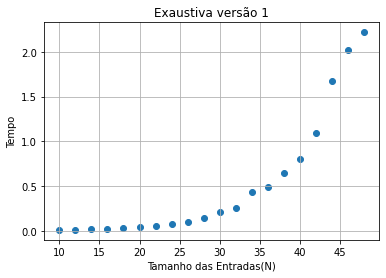

In [56]:
import matplotlib.pyplot as plt

plt.scatter(ex1_en, tempos_ex1)
plt.xlabel("Tamanho das Entradas(N)")
plt.ylabel("Tempo")
plt.title("Exaustiva versão 1")
plt.grid()
plt.show()

Como dito anteriormente, é possível observar que conforme o tamanho das sequências aumenta, o tempo de processamento do alinhamento também aumenta de maneira expressiva, sendo possível rodar apenas entradas com tamanhos menores ou iguais a 45 letras. Outro fator que contribui para tal valor máximo é que para cada um dos tamanhos, 100 entradas diferentes foram rodadas para adquirir uma média realista do tempo de processamento.

#### A Busca Exaustiva com OpenMP
---


Para tentar melhorar o desempenho da busca exaustiva, a primeira tentativa foi utilizar o OpenMP para parallizar o código, fazendo com que cada combinação seja calculada simultaneamente com as outras, através de múltiplos processadores. Essa estratégia necessitou da utilizaçao de múltiplas threads para o cálculo do score de cada combinação e, posteriormente, foi adquirido o maior score dentre todas as combinações.

O desempenho da paralelização pode ser observado abaixo: 




In [36]:
tempos_ex_omp=[]

In [37]:
for i in range(10,50,2):
    avg_time=[]
    for j in range (0,100):
        out, time= roda_com_entrada('./Exaustiva_openMP/exaustiva_paralela', 'Entradas/exaustiva/dna{0}_{1}.seq'.format(i,j))
        avg_time.append(time)
    tempos_ex_omp.append(np.mean(avg_time))

In [51]:
ex_omp_en = []
for i in entradas:
    if i not in ex_omp_en:
        ex_omp_en.append(i)

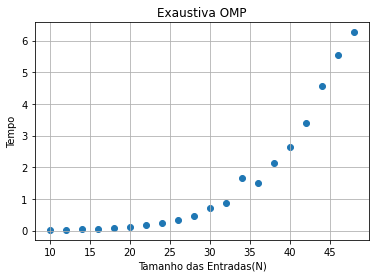

In [53]:
import matplotlib.pyplot as plt

plt.scatter(ex_omp_en, tempos_ex_omp)
plt.xlabel("Tamanho das Entradas(N)")
plt.ylabel("Tempo")
plt.title("Exaustiva OMP")
plt.grid()
plt.show()

Ao contrário do que se esperava, a utilização do paralelismo acabou deixando sua perfomance pior. Isso ocorreu pois apesar de dividir o cálculo das combinações em threads, cada uma delas precisava ter exclusividade na hora de calcular o score com a matriz dinâmica, ou os valores não seriam confiáveis. Por isso, a execução do programa acaba adquirindo um caráter sequencial também, e até pior que o código original.

#### A Busca Exaustiva com GPU
---


Outro método de paralelismo aplicado foi o uso da GPU para calcular grandes quantidades de combinações de maneira simultânea, otimizando o algoritmo exaustivo. Para isso, utilizou-se a biblioteca Thrust, junto com o OpenMP. Seu desempenho pode ser obeservado abaixo: 

*Para rodar esse arquivo, foi necessário rodar as células comentadas com  o google colab e os valores adquiridos foram passados para as listas**

In [87]:
tempos_ex_gpu=[0.9959394311001233,
 1.6046554642001865,
 2.5016621556998873,
 4.365136233400335,
 5.683432581599845,
 7.923057561199675,
 13.288470274300561,
 17.82763756350032,
 26.917057605099764,
 27.900513365699954]


ex_gpu_en=[10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28]

In [78]:
# for i in range(10,30,2):
#     avg_time=[]
#     for j in range (0,10):
#         out, time= roda_com_entrada('./Exaustiva_GPU/exaustiva_final', 'Entradas/exaustiva/dna{0}_{1}.seq'.format(i,j))
#         avg_time.append(time)
#     tempos_ex_gpu.append(np.mean(avg_time))

In [93]:
# ex_gpu_en = []
# for i in entradas:
#     if i not in ex_gpu_en:
#         ex_gpu_en.append(i)

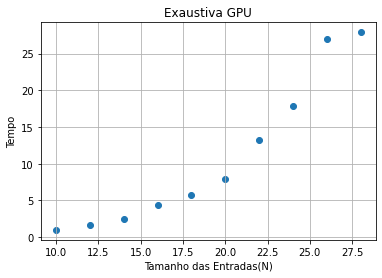

In [88]:
import matplotlib.pyplot as plt

plt.scatter(ex_gpu_en, tempos_ex_gpu)
plt.xlabel("Tamanho das Entradas(N)")
plt.ylabel("Tempo")
plt.title("Exaustiva GPU")
plt.grid()
plt.show()

Diferente do esperado, a GPU obteve um resultado inferior às estratégias anteriores, aguentando rodar entradas com o tamanho máximo de 30 ao invés de 50, e com  um tempo expressivamente mais alto. 

#### Comparando as estratégias
---

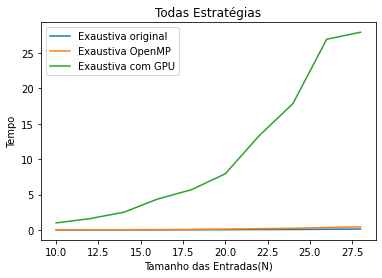

In [91]:
plt.plot(ex1_en[:10], tempos_ex1[:10], label="Exaustiva original")
plt.plot(ex_omp_en[:10], tempos_ex_omp[:10], label="Exaustiva OpenMP")
plt.plot(ex_gpu_en, tempos_ex_gpu, label="Exaustiva com GPU")
plt.title("Todas Estratégias")
plt.xlabel("Tamanho das Entradas(N)")
plt.ylabel("Tempo")
plt.legend()
plt.show()

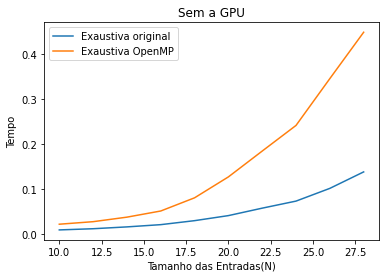

In [92]:
plt.plot(ex1_en[:10], tempos_ex1[:10], label="Exaustiva original")
plt.plot(ex_omp_en[:10], tempos_ex_omp[:10], label="Exaustiva OpenMP")
plt.xlabel("Tamanho das Entradas(N)")
plt.title('Sem a GPU')
plt.ylabel("Tempo")
plt.legend()
plt.show()

Como é possível observar pelos gráficos acima, surpreendentemente a busca exaustiva sem paralelismo foi a que obteve o melhor desempenho. Tal fato pode ser explicado pelo modo em que o score é calculado. Por fazer uso de uma matriz dinâmica, a paralelização da busca exaustiva possui uma alta complexidade dado que na estratégia com  a CPU cada thread precisa utilizar a matriz de maneira exclusiva, e não compartilhada, deixando a perfomance do código sequencial. Por outro lado, o método que utiliza a GPU não foi eficaz pois a vazão de dados não foi grande o suficiente para que a GPU se destacasse. Isso ocorreu pois inicialmente desejava-se  utilizar apenas uma transformação do thrust que carregasse todas as combinações possíveis de substrings para a GPU, permitindo assim que os scores fossem calculados simultaneamente. Porém, por uma limitação da GPU em lidar com strings diretamente, foi necessário deixar apenas a parte do cálculo da matriz na GPU, sem enviar todas as combinações de uma vez,  diminuindo drasticamente seu desempenho, mesmo quando combinada com o OpenMP. Tal fato é proveniente da penalidade que existe ao rodar um código com grande parte sequencial em uma GPU.

Desse modo, o paralelismo com GPU ainda é a melhor opção para uma grande quantidade de dados, desde que o algoritmo seja aplicado da maneira correta, sendo necessárias iterações para que o desempenho do código apresentado melhore significamente. Por fim, no último relatório foi possível observar que utilizar uma Heurística, embora não garanta um resultado ótimo, é uma opção que deve ser considerada para problemas complexos como esse, haja vista seu tempo de execução extremamente baixo frente aos tempos elevados que a Busca exaustiva fornece.